<p>For this problem you will use a different subset of the 20 Newsgroup data set that you used in Assignment 2  (see the description of the full dataset). The subset for this assignment includes 2,500 documents (newsgroup posts), each belonging to one of 5 categories windows (0), crypt (1), christian (2), hockey (3), forsale (4). The documents are represented by 9328 terms (stems). The dictionary (vocabulary) for the data set is given in the file "terms.txt" and the full term-by-document matrix is given in "matrix.txt" (comma separated values). The actual category labels for the documents are provided in the file "classes.txt". Your goal in this assignment is to perform clustering on the documents and compare the clusters to the actual categories.

Your tasks in this problem are the following [Note: for the clustering part of this assignment you should use the kMeans module form Ch. 10 of MLA (use the version provided here as it includes some corrections to the book version). You may also use Pandas and other modules from scikit-learn that you may need for preprocessing or evaluation.] </p>

In [1]:
# load the necessary packages
# load the necessary packages
import numpy as np
import pandas as pd
import operator
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.model_selection import train_test_split 
import pylab as pl
from sklearn import feature_selection
from sklearn import model_selection
from sklearn.metrics import completeness_score, homogeneity_score
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

pd.set_option("display.precision", 4)
np.set_printoptions(precision=4)
plt.style.use('ggplot')

##### a. Create your own distance function that, instead of using Euclidean distance, uses Cosine similarity. This is the distance function you will use to pass to the kMeans function.

In [2]:
'''
k Means Clustering for Ch10 of Machine Learning in Action
@author: Peter Harrington
'''
from numpy import *

def distEuclid(vecA, vecB):
    return sqrt(sum(power(vecA - vecB, 2))) #la.norm(vecA-vecB)

In [3]:
def cosineDist(vecA, vecB):
    """Function that returns cosine Similarity"""
    a_norm = np.linalg.norm(vecA)
    b_norm = np.linalg.norm(vecB)
    
    cosine = np.dot(vecA, vecB) / (a_norm * b_norm)
    dist = 1 - cosine
    
    return dist

In [4]:
def randCent(dataSet, k):
    '''
    randCent(), creates a set of k ran-dom  centroids  for  a  given  dataset.  
    The  random  centroids  need  to  be  within  thebounds of the dataset. 
    This is accomplished by finding the minimum and maximumvalues of each dimension 
    in the dataset. 
    Random values from 0 to 1.0 are then chosenand  scaled  by  the  range  and  
    minimum  value  to  ensure  that  the  random  points  arewithin  the  bounds  
    of  the  data.  
    '''
    n = shape(dataSet)[1]
    centroids = zeros((k,n), dtype=float)
    for j in range(n): #create random cluster centers
        minJ = min(dataSet[:,j])
        rangeJ = float(max(dataSet[:,j]) - minJ)
        centroids[:,j] = minJ + rangeJ * random.rand(k)
    return centroids 

In [5]:
# kMeans function
def kMeans(dataSet, k, distMeas=distEuclid, createCent=randCent):
    m = shape(dataSet)[0]
    clusterAssment = zeros((m,2)) #create mat to assign data points 
                                  #to a centroid, also holds SE of each point
    centroids = createCent(dataSet, k)
    clusterChanged = True
    while clusterChanged:
        clusterChanged = False
        for i in range(m): #for each data point assign it to the closest centroid
            minDist = inf; minIndex = -1
            for j in range(k):  #find the closest distance
                distJI = distMeas(centroids[j,:],dataSet[i,:])
                if distJI < minDist:
                    minDist = distJI; minIndex = j
            if clusterAssment[i,0] != minIndex: clusterChanged = True
            clusterAssment[i,:] = minIndex,minDist**2
        # print centroids
        for cent in range(k):#recalculate centroids and update the centroid location
            ptsInClust = dataSet[nonzero(clusterAssment[:,0]==cent)[0]] #get all the point in this cluster - Note: this was incorrect in the original distribution.
            if(len(ptsInClust)!=0):
                centroids[cent,:] = mean(ptsInClust, axis=0) #assign centroid to mean - Note condition was added 10/28/2013
    return centroids, clusterAssment

In [6]:
def biKmeans(dataSet, k, distMeas=distEuclid):
    '''
    To overcome the problem of poor clusters because of k-means getting caught in a local minimum, another algorithm has been developed. This algorithm, known as bisecting k-means, starts out with one cluster and then splits the cluster in two. It then chooses a cluster to split. The cluster to split is decided by minimizing the SSE. This splitting based on the SSE is repeated until the user-defined number of clusters is attained.
    '''
    m = shape(dataSet)[0]
    clusterAssment = mat(zeros((m,2))) # cluster assessment has two columns, one column is for the index of the cluster and the second column is store the error. 
    # This error is the distance from the cluster centroid to the current point. We’ll use this error later on to measure how good our clusters are
    centroid0 = mean(dataSet, axis=0).tolist()[0]
    centList =[centroid0] #create a list with one centroid
    for j in range(m): #calc initial Error
        clusterAssment[j,1] = distMeas(mat(centroid0), dataSet[j,:])**2
    while (len(centList) < k):
        lowestSSE = inf
        for i in range(len(centList)):
            ptsInCurrCluster = dataSet[nonzero(clusterAssment[:,0].A==i)[0],:] #get the data points currently in cluster i
            centroidMat, splitClustAss = kMeans(ptsInCurrCluster, 2, distMeas)
            sseSplit = sum(splitClustAss[:,1]) #compare the SSE to the currrent minimum
            sseNotSplit = sum(clusterAssment[nonzero(clusterAssment[:,0].A!=i)[0],1])
            print("sseSplit, and notSplit: ",sseSplit,sseNotSplit)
            if (sseSplit + sseNotSplit) < lowestSSE:
                bestCentToSplit = i
                bestNewCents = centroidMat
                bestClustAss = splitClustAss.copy()
                lowestSSE = sseSplit + sseNotSplit
        bestClustAss[nonzero(bestClustAss[:,0] == 1)[0],0] = len(centList) #change 1 to 3,4, or whatever
        bestClustAss[nonzero(bestClustAss[:,0] == 0)[0],0] = bestCentToSplit
        print('the bestCentToSplit is: ',bestCentToSplit)
        print('the len of bestClustAss is: ', len(bestClustAss))
        centList[bestCentToSplit] = bestNewCents[0,:].tolist()[0] #replace a centroid with two best centroids 
        centList.append(bestNewCents[1,:].tolist()[0])
        clusterAssment[nonzero(clusterAssment[:,0].A == bestCentToSplit)[0],:]= bestClustAss #reassign new clusters, and SSE
    return mat(centList), clusterAssment


#### b. Load the data set [Note: the data matrix provided has terms as rows and documents as columns. Since you will be clustering documents, you'll need to take the transpose of this matrix so that your main data matrix is a document x term matrix. In Numpy, you may use the ".T" operation to obtain the transpose.] Then, split the data set (the document x term matrix) and set aside 20% for later use (see below). Use the 80% segment for clustering in the next part. The 20% portion must be a random subset. Next, as in the previous assignment, perform TFxIDF transformation on these data sets

In [7]:
### load the data set
fileName_Classes = r'../../data/newsgroups5/classes.txt'
df_classes = pd.read_csv(fileName_Classes, sep = '\s+', header = None, skiprows = 1, index_col = 0)
df_classes.head()

,1
0,
0,0
1,1
2,1
3,1
4,2


In [8]:
df_classes.shape

(2500, 1)

In [9]:
df_classes.head()

,1
0,
0,0
1,1
2,1
3,1
4,2


In [10]:
df_classes.columns

Int64Index([1], dtype='int64')

In [11]:
%time
fileName_matrix = r'../../data/newsgroups5/matrix.txt'
df_matrix = pd.read_csv(fileName_matrix, header = None)
df_matrix.head() # display the first five records

Wall time: 0 ns


,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
df_matrix.shape

(9328, 2500)

In [13]:
fileName_terms = r'../../data/newsgroups5/terms.txt'
df_terms = pd.read_csv(fileName_terms, header = None)
df_terms.head() # display the first five records

,0
0,aa
1,aargh
2,aaron
3,aaronc
4,ab


#### We need to add the terms frequency across the columns

In [14]:
termFreqs = df_matrix.sum(axis = 1) # adding in the column direction
termFreqs

0       16
1        6
2       82
3       12
4       30
        ..
9323     8
9324    50
9325    11
9326     6
9327    15
Length: 9328, dtype: int64

<p>aa appears times 16 times, aargh appears 6 times, aaron appears 12 times and so on.</p>

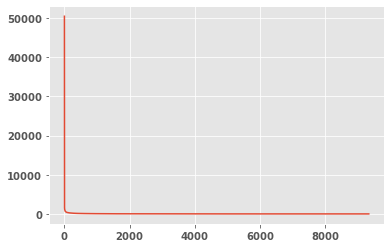

In [15]:
plt.plot(sorted(termFreqs, reverse=True))
plt.show()

#### Since we will be clustering documents, we'll need to take the transpose of this matrix so that our main data matrix is a document x term matrix. 

In [16]:
DT = df_matrix.T
DT.head()

,0,1,2,3,4,5,6,7,8,9,...,9318,9319,9320,9321,9322,9323,9324,9325,9326,9327
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
DT.shape

(2500, 9328)

#### We now have a document term matrix

In [18]:
numTerms = df_matrix.shape[0]
NDocs = df_matrix.shape[1]
print('There are %s terms.' %numTerms)
print('There are %s documents.' %NDocs)

There are 9328 terms.
There are 2500 documents.


#### Though TFxIDF weights are not necessary for clustering, we will transform the data to TFxIDF weights

In [19]:
matrix_DF = pd.DataFrame([(df_matrix != 0).sum(1)]).T
matrix_DF

,0
0,10
1,6
2,22
3,9
4,13
...,...
9323,6
9324,5
9325,3
9326,3


In [20]:
# create a matrix with all entries = NDocs
NMatrix=np.ones(np.shape(df_matrix), dtype = float) * NDocs
np.set_printoptions(precision = 2,suppress = True,linewidth = 120)
print(NMatrix)

[[2500. 2500. 2500. ... 2500. 2500. 2500.]
 [2500. 2500. 2500. ... 2500. 2500. 2500.]
 [2500. 2500. 2500. ... 2500. 2500. 2500.]
 ...
 [2500. 2500. 2500. ... 2500. 2500. 2500.]
 [2500. 2500. 2500. ... 2500. 2500. 2500.]
 [2500. 2500. 2500. ... 2500. 2500. 2500.]]


In [21]:
# Convert each entry into IDF values
# IDF is the log of the inverse of document frequency
# Note that IDF is only a function of the term, so all columns will be identical.
IDF = np.log2(np.divide(NMatrix, np.array(matrix_DF)))

np.set_printoptions(precision=2,suppress=True)
print(IDF)

[[7.97 7.97 7.97 ... 7.97 7.97 7.97]
 [8.7  8.7  8.7  ... 8.7  8.7  8.7 ]
 [6.83 6.83 6.83 ... 6.83 6.83 6.83]
 ...
 [9.7  9.7  9.7  ... 9.7  9.7  9.7 ]
 [9.7  9.7  9.7  ... 9.7  9.7  9.7 ]
 [9.29 9.29 9.29 ... 9.29 9.29 9.29]]


In [22]:
#### Finally computer the TF x IDF values for each document - term entry
TD_tfidf = df_matrix * IDF

In [23]:
pd.set_option("display.precision", 2)

TD_tfidf

,0,1,2,3,4,5,6,7,8,9,...,2490,2491,2492,2493,2494,2495,2496,2497,2498,2499
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9324,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9325,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9326,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
type(TD_tfidf)

pandas.core.frame.DataFrame

#### We also need to transpose the TD_ftidf matrix 

In [25]:
TD_tfidf_tranposed = TD_tfidf.T
TD_tfidf_tranposed.shape

(2500, 9328)

#### create a 20%-80% randomized split of the data for later use.

In [26]:
# train_test_split shuffles the data and splits it into two split for us into 80% training and 20% percent testing.
vs_train, vs_test, vs_target_train, vs_target_test = train_test_split(TD_tfidf_tranposed, df_classes, test_size = 0.2, random_state = 33)

#### let's look at the shapes of the training and test data matrices.

In [27]:

vs_train.shape

(2000, 9328)

In [28]:
vs_test.shape

(500, 9328)

In [29]:
vs_target_train.shape

(2000, 1)

In [30]:
vs_target_test.shape

(500, 1)

In [31]:
vs_train.head()

,0,1,2,3,4,5,6,7,8,9,...,9318,9319,9320,9321,9322,9323,9324,9325,9326,9327
1289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1935,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2349,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
vs_test.head()

,0,1,2,3,4,5,6,7,8,9,...,9318,9319,9320,9321,9322,9323,9324,9325,9326,9327
1590,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
277,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
511,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
vs_target_train.head()

,1
0,
1289,4
596,0
1935,4
2436,4
2349,1


#### Convert the training and testing data matrices into numpy array

In [34]:
vs_train_array = np.array(vs_train)
vs_target_train_array = vs_target_train[1].values.tolist()
vs_target_test_array = np.array(vs_target_test)

In [35]:
vs_target_train_array[:20]

[4, 0, 4, 4, 1, 2, 0, 2, 2, 4, 4, 3, 4, 2, 2, 2, 0, 3, 4, 4]

#### c. Perform Kmeans clustering on the transformed training data from part (b) [Note: if you have difficulty with TFxIDF conversion, then use the original non-transformed data for the remainder of this assignment].

In [36]:
def clusterAnalysis(centroids, clusterAssment, vs_train, df_terms):
    
    doc_cluster = pd.DataFrame(clusterAssment, columns = ['Cluster','error'])
    
    target_labels = doc_cluster['Cluster'].unique()
#     print(target_labels)
    
    doc_cluster_size = {}   # declare an empty dictionary of cluster sizes
    
    booleanFlag = None       # flag for subselection
    
    termsDF = pd.DataFrame(df_terms[0].values.tolist(), columns = ['term'])
    

    for c in target_labels:
        # assign term index to each of the clusters.
        cluster_index_TrainData = vs_train.index[doc_cluster['Cluster'] == int(c)]


        centroidsWeights = pd.DataFrame(centroids[int(c)], columns =['Weights'])

        # determine the cluster size
        clusterSize = len(vs_train.index[doc_cluster['Cluster'] == int(c)])

        # populate a dictionary of cluster sizes.
        doc_cluster_size[int(c)] = clusterSize

        #Check whether the training data (tfidx document * term ) set's index are in the cluster_index_TrainData
        booleanFlag = vs_train.index.isin(cluster_index_TrainData)

        clusterDocs = vs_train[booleanFlag]

        # let's find the document counts for each term by transposing clusterDocs to get term by document and counting all the non zero terms

        clusterDocsT = clusterDocs.T

        DocTermFreq = pd.DataFrame([(clusterDocsT != 0).sum(1)]).T


        DocTermFreq.columns = ['DF']

        DocTermFreq['% of Ndocs'] = DocTermFreq['DF'] / doc_cluster_size[int(c)] * 100

        # lets merge the terms, centroid and DocTermFreqPercentage
        print('Cluster %s\n\n\nCluster size: %s\n\n Top 5 terms in Cluster %s \n\n' %(int(c), doc_cluster_size[int(c)], int(c)))
        clusterTermCentroid = pd.concat([termsDF, centroidsWeights ,DocTermFreq], axis = 1)


        # Sort the data frame by % of Ndocs in descending order
        sortedClTerm = clusterTermCentroid.sort_values(['DF', 'Weights'], ascending = False)
        
        # Select the Top 5 records from the sorted Data Frame
        top5Rows = sortedClTerm[['term', 'DF', '% of Ndocs']].head()   
        emptyIndex = [''] * len(top5Rows)
        top5Rows.index = emptyIndex
        print('%s \n' %top5Rows)
        print('*'*40)
    return sortedClTerm
        

In [37]:
%time
# (dataSet, k, distMeas=distEuclid, createCent=randCent)
print('Running Kmeans when k = 4')
centroids4, clusterAssment4 = kMeans(vs_train_array, 4, cosineDist, randCent)

Wall time: 0 ns
Running Kmeans when k = 4


In [38]:
clusterAnalysis(centroids4, clusterAssment4, vs_train, df_terms)

Cluster 1


Cluster size: 810

 Top 5 terms in Cluster 1 


    term   DF  % of Ndocs
  window  296       36.54
   email  236       29.14
   write  235       29.01
   thank  229       28.27
      on  229       28.27 

****************************************
Cluster 3


Cluster size: 788

 Top 5 terms in Cluster 3 


    term   DF  % of Ndocs
   write  481       61.04
  articl  372       47.21
      on  327       41.50
     get  278       35.28
      go  267       33.88 

****************************************
Cluster 2


Cluster size: 394

 Top 5 terms in Cluster 2 


       term   DF  % of Ndocs
      write  244       61.93
         on  218       55.33
        god  214       54.31
     articl  186       47.21
  christian  180       45.69 

****************************************
Cluster 0


Cluster size: 8

 Top 5 terms in Cluster 0 


 term  DF  % of Ndocs
   ax   7        87.5
  max   7        87.5
   pl   6        75.0
  giz   6        75.0
  bxn   6        75.0 

*************

,term,Weights,DF,% of Ndocs
547,ax,41973.81,7,87.5
4982,max,2877.51,7,87.5
6183,pl,315.20,6,75.0
3302,giz,185.44,6,75.0
1052,bxn,136.75,6,75.0
...,...,...,...,...
9322,zu,0.00,0,0.0
9323,zubov,0.00,0,0.0
9324,zv,0.00,0,0.0
9326,zx,0.00,0,0.0


In [39]:
%time
# (dataSet, k, distMeas=distEuclid, createCent=randCent)
print('Running Kmeans when k = 5')
centroids5, clusterAssment5 = kMeans(vs_train_array, 5, cosineDist, randCent)

Wall time: 0 ns
Running Kmeans when k = 5


In [40]:
sortedClTerm = clusterAnalysis(centroids5, clusterAssment5, vs_train, df_terms)

Cluster 1


Cluster size: 744

 Top 5 terms in Cluster 1 


    term   DF  % of Ndocs
  window  294       39.52
    sale  218       29.30
   write  213       28.63
   email  207       27.82
   thank  207       27.82 

****************************************
Cluster 4


Cluster size: 459

 Top 5 terms in Cluster 4 


     term   DF  % of Ndocs
    write  283       61.66
   articl  213       46.41
       on  198       43.14
      kei  189       41.18
  clipper  189       41.18 

****************************************
Cluster 0


Cluster size: 787

 Top 5 terms in Cluster 0 


    term   DF  % of Ndocs
   write  464       58.96
      on  368       46.76
  articl  357       45.36
   think  295       37.48
      go  277       35.20 

****************************************
Cluster 3


Cluster size: 2

 Top 5 terms in Cluster 3 


  term  DF  % of Ndocs
    db   2       100.0
  test   2       100.0
  type   2       100.0
   got   2       100.0
   two   2       100.0 

*******************

In [41]:
pd.options.display.float_format='{:,.2f}'.format
clusterCentroids5 = pd.DataFrame(centroids5, columns = df_terms[0].values.tolist())
clusterCentroids5.head()

,aa,aargh,aaron,aaronc,ab,abandon,abc,abid,abil,abl,...,zq,zr,zrb,zs,zu,zubov,zv,zw,zx,zz
0,0.02,0.04,0.57,0.08,0.10,0.07,0.34,0.01,0.15,0.34,...,0.08,0.01,0.04,0.03,0.01,0.09,0.36,0.02,0.01,0.02
1,0.03,0.00,0.06,0.00,0.04,0.01,0.00,0.00,0.11,0.29,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.95,0.00,0.00,0.00,0.00,0.00,...,0.00,1.12,0.00,13.05,0.00,0.00,0.00,1.21,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.03,0.00,0.00,0.00,0.05,0.04,0.03,0.02,0.27,0.45,...,0.04,0.12,0.00,0.00,0.06,0.00,0.00,0.00,0.00,0.08


In [42]:
# List all articles in a cluster
# centroidsTest  = for in range(centroids5.shape[0])
centroids5.shape[0]

5

In [43]:

print(sortedClTerm.shape[0])

9328


In [44]:
doc_cluster = pd.DataFrame(clusterAssment5, columns = ['Cluster','error'])
doc_cluster.head()

,Cluster,error
0,1.00,0.87
1,1.00,0.91
2,1.00,0.81
3,1.00,0.86
4,4.00,0.73


In [45]:
%time
# (dataSet, k, distMeas=distEuclid, createCent=randCent)
print('Running Kmeans when k = 6')
centroids6, clusterAssment6 = kMeans(vs_train_array, 6, cosineDist, randCent)

Wall time: 0 ns
Running Kmeans when k = 6


In [46]:
clusterAnalysis(centroids6, clusterAssment6, vs_train, df_terms)

Cluster 2


Cluster size: 364

 Top 5 terms in Cluster 2 


   term   DF  % of Ndocs
   sale  220       60.44
  email  139       38.19
  pleas  116       31.87
  offer  104       28.57
   ship   97       26.65 

****************************************
Cluster 5


Cluster size: 397

 Top 5 terms in Cluster 5 


    term   DF  % of Ndocs
   write  222       55.92
    game  212       53.40
    team  194       48.87
      go  177       44.58
  articl  172       43.32 

****************************************
Cluster 0


Cluster size: 794

 Top 5 terms in Cluster 0 


    term   DF  % of Ndocs
   write  510       64.23
      on  400       50.38
  articl  389       48.99
   peopl  303       38.16
    know  297       37.41 

****************************************
Cluster 1


Cluster size: 436

 Top 5 terms in Cluster 1 


    term   DF  % of Ndocs
  window  282       64.68
   write  198       45.41
    file  154       35.32
     get  150       34.40
      on  145       33.26 

***********

,term,Weights,DF,% of Ndocs
1984,db,"4,373.22",1,100.00
742,bh,"1,035.63",1,100.00
1845,cs,612.13,1,100.00
7447,si,546.07,1,100.00
1060,byte,445.81,1,100.00
...,...,...,...,...
9323,zubov,0.00,0,0.00
9324,zv,0.00,0,0.00
9325,zw,0.00,0,0.00
9326,zx,0.00,0,0.00


In [47]:
%time
# (dataSet, k, distMeas=distEuclid, createCent=randCent)
print('Running Kmeans when k = 7')
centroids7, clusterAssment7 = kMeans(vs_train_array, 7, cosineDist, randCent)

Wall time: 0 ns
Running Kmeans when k = 7


In [48]:
clusterAnalysis(centroids7, clusterAssment7, vs_train, df_terms)

Cluster 3


Cluster size: 478

 Top 5 terms in Cluster 3 


   term   DF  % of Ndocs
   sale  225       47.07
  email  155       32.43
  pleas  132       27.62
     on  111       23.22
  offer  106       22.18 

****************************************
Cluster 4


Cluster size: 394

 Top 5 terms in Cluster 4 


     term   DF  % of Ndocs
    write  266       67.51
   articl  204       51.78
  clipper  186       47.21
      kei  185       46.95
  encrypt  183       46.45 

****************************************
Cluster 2


Cluster size: 697

 Top 5 terms in Cluster 2 


    term   DF  % of Ndocs
   write  422       60.55
      on  349       50.07
  articl  321       46.05
   think  271       38.88
    know  247       35.44 

****************************************
Cluster 0


Cluster size: 399

 Top 5 terms in Cluster 0 


    term   DF  % of Ndocs
  window  277       69.42
   write  178       44.61
    file  145       36.34
     get  133       33.33
      on  133       33.33 

*****

,term,Weights,DF,% of Ndocs
547,ax,"55,962.62",6,100.00
4982,max,"3,834.34",6,100.00
6183,pl,420.27,6,100.00
3302,giz,247.25,6,100.00
1052,bxn,182.33,6,100.00
...,...,...,...,...
9322,zu,0.00,0,0.00
9323,zubov,0.00,0,0.00
9324,zv,0.00,0,0.00
9326,zx,0.00,0,0.00


In [49]:
%time
# (dataSet, k, distMeas=distEuclid, createCent=randCent)
print('Running Kmeans when k = 8')
centroids8, clusterAssment8 = kMeans(vs_train_array, 8, cosineDist, randCent)

Wall time: 0 ns
Running Kmeans when k = 8


In [50]:
centroids8

array([[0.  , 0.09, 0.02, ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.02, 0.  , 1.09, ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [2.28, 0.  , 0.  , ..., 2.77, 1.39, 7.96],
       [0.04, 0.  , 0.06, ..., 0.  , 0.  , 0.  ]])

In [51]:
clusterAnalysis(centroids8, clusterAssment8, vs_train, df_terms)

Cluster 7


Cluster size: 766

 Top 5 terms in Cluster 7 


    term   DF  % of Ndocs
  window  295       38.51
    sale  225       29.37
   write  222       28.98
      on  221       28.85
   email  215       28.07 

****************************************
Cluster 0


Cluster size: 401

 Top 5 terms in Cluster 0 


    term   DF  % of Ndocs
   write  222       55.36
    game  214       53.37
    team  191       47.63
      go  176       43.89
  articl  173       43.14 

****************************************
Cluster 5


Cluster size: 389

 Top 5 terms in Cluster 5 


     term   DF  % of Ndocs
    write  263       67.61
   articl  198       50.90
  clipper  186       47.81
      kei  183       47.04
  encrypt  182       46.79 

****************************************
Cluster 2


Cluster size: 407

 Top 5 terms in Cluster 2 


    term   DF  % of Ndocs
   write  251       61.67
      on  227       55.77
     god  215       52.83
  articl  194       47.67
   peopl  185       45.45 


,term,Weights,DF,% of Ndocs
547,ax,"47,970.07",7,100.00
4982,max,"3,286.57",6,85.71
6183,pl,360.23,6,85.71
3302,giz,211.93,6,85.71
1052,bxn,156.28,6,85.71
...,...,...,...,...
9322,zu,0.00,0,0.00
9323,zubov,0.00,0,0.00
9324,zv,0.00,0,0.00
9326,zx,0.00,0,0.00


##### [Extra Credit - 5pt: use your favorite third party tool, ideally with a Python based API, to create a word cloud for each cluster.]


In [52]:
print('Running Kmeans when k = 5')
centroids5, clusterAssment5 = kMeans(vs_train_array, 5, cosineDist, randCent)

Running Kmeans when k = 5


In [53]:
def clusterAnalysis_with_weights(centroids, clusterAssment, k, vs_train, df_terms):
    
    doc_cluster = pd.DataFrame(clusterAssment, columns = ['Cluster','error'])
    
    target_labels = doc_cluster['Cluster'].unique()

    doc_cluster_size = {}   # declare an empty dictionary of cluster sizes
    
    booleanFlag = None       # flag for subselection
    
    termsDF = pd.DataFrame(df_terms[0].values.tolist(), columns = ['term'])
    
    for c in target_labels:
        # assign term index to each of the clusters.
        cluster_index_TrainData = vs_train.index[doc_cluster['Cluster'] == int(c)]


        centroidsWeights = pd.DataFrame(centroids[int(c)], columns =['Weights'])

        # determine the cluster size
        clusterSize = len(vs_train.index[doc_cluster['Cluster'] == int(c)])

        # populate a dictionary of cluster sizes.
        doc_cluster_size[int(c)] = clusterSize

        #Check whether the training data (tfidx document * term ) set's index are in the cluster_index_TrainData
        booleanFlag = vs_train.index.isin(cluster_index_TrainData)

        clusterDocs = vs_train[booleanFlag]

        # let's find the document counts for each term by transposing clusterDocs to get term by document and counting all the non zero terms

        clusterDocsT = clusterDocs.T

        DocTermFreq = pd.DataFrame([(clusterDocsT != 0).sum(1)]).T


        DocTermFreq.columns = ['DF']

        DocTermFreq['% of Ndocs'] = DocTermFreq['DF'] / doc_cluster_size[int(c)] * 100

        # lets merge the terms, centroid and DocTermFreqPercentage
#         print('Cluster %s\n\n\nCluster size: %s\n\n Top 5 terms in Cluster %s \n\n' %(int(c), doc_cluster_size[int(c)], int(c)))
        clusterTermCentroid = pd.concat([termsDF, centroidsWeights ,DocTermFreq], axis = 1)

        # Sort the data frame by % of Ndocs in descending order
        sortedClTerm = clusterTermCentroid.sort_values(['DF', 'Weights'], ascending = False)

        # Derive the data set for the word Cloud based on the weights.
        weights = pd.Series(sortedClTerm['Weights'].round(decimals = 2).values.tolist())
        weights.index = sortedClTerm['term']
        dict_weights = weights.to_dict() # Convert the Series into dictionary
        cloud = WordCloud(width=900, height=700, background_color = 'white' ).generate_from_frequencies(dict_weights)
        print('Word cloud based on all terms within Cluster %s when k = %s \n' %(str(int(c)), k))

        # reset the index
        emptyIndex = [''] * sortedClTerm.shape[0]
        sortedClTerm.index = emptyIndex
        print(sortedClTerm)

        plt.imshow(cloud, interpolation = 'bilinear')
        plt.axis('off')
        plt.show()

Word cloud based on all terms within Cluster 2 when k = 5 

     term  Weights   DF  % of Ndocs
     sale     2.67  220       58.51
    email     1.12  147       39.10
    pleas     0.97  123       32.71
    offer     1.50  104       27.66
     ship     1.61   97       25.80
..    ...      ...  ...         ...
    zubov     0.00    0        0.00
       zv     0.00    0        0.00
       zw     0.00    0        0.00
       zx     0.00    0        0.00
       zz     0.00    0        0.00

[9328 rows x 4 columns]


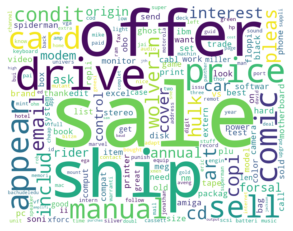

Word cloud based on all terms within Cluster 4 when k = 5 

                term  Weights   DF  % of Ndocs
               write     0.86  485       61.47
              articl     0.89  374       47.40
                  on     1.09  328       41.57
                 get     1.21  279       35.36
                  go     1.31  267       33.84
..               ...      ...  ...         ...
                zhao     0.00    0        0.00
    zikzakapanaorgau     0.00    0        0.00
                 zkn     0.00    0        0.00
           zoeraster     0.00    0        0.00
                zoom     0.00    0        0.00

[9328 rows x 4 columns]


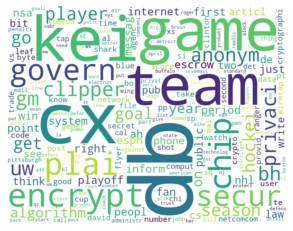

Word cloud based on all terms within Cluster 0 when k = 5 

         term  Weights   DF  % of Ndocs
        write     0.90  244       62.09
           on     1.95  218       55.47
          god     7.27  214       54.45
       articl     0.93  186       47.33
    christian     5.00  179       45.55
..        ...      ...  ...         ...
        zubov     0.00    0        0.00
           zv     0.00    0        0.00
           zw     0.00    0        0.00
           zx     0.00    0        0.00
           zz     0.00    0        0.00

[9328 rows x 4 columns]


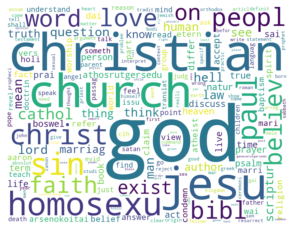

Word cloud based on all terms within Cluster 1 when k = 5 

      term  Weights   DF  % of Ndocs
    window     5.34  280       64.52
     write     0.67  199       45.85
      file     4.01  154       35.48
       get     0.93  148       34.10
        on     0.75  146       33.64
..     ...      ...  ...         ...
     zubov     0.00    0        0.00
        zv     0.00    0        0.00
        zw     0.00    0        0.00
        zx     0.00    0        0.00
        zz     0.00    0        0.00

[9328 rows x 4 columns]


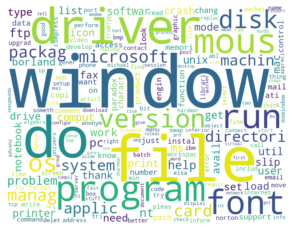

Word cloud based on all terms within Cluster 3 when k = 5 

     term   Weights  DF  % of Ndocs
       ax 41,973.81   7       87.50
      max  2,877.51   7       87.50
       pl    315.20   6       75.00
      giz    185.44   6       75.00
      bxn    136.75   6       75.00
..    ...       ...  ..         ...
       zu      0.00   0        0.00
    zubov      0.00   0        0.00
       zv      0.00   0        0.00
       zx      0.00   0        0.00
       zz      0.00   0        0.00

[9328 rows x 4 columns]


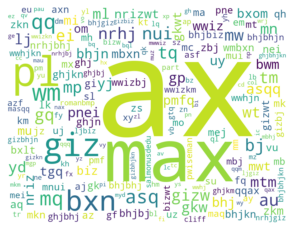

In [54]:
clusterAnalysis_with_weights(centroids5, clusterAssment5, 5, vs_train, df_terms)

### d. Using the cluster assignments from your Kmeans clustering and the original cluster labels for the training document, compare your clusters to the re-assigned classes by computing the Completeness and Homogeneity values. You should do this for the best values of k and the best clustering run you settled on in the previous part. 

In [55]:
docCluster5 = pd.DataFrame(clusterAssment5, columns = ['Cluster','error']) 

In [56]:
newC5 = docCluster5['Cluster'].astype(int)
newC5.head()

0    2
1    4
2    2
3    2
4    4
Name: Cluster, dtype: int32

In [57]:
print(completeness_score(vs_target_train_array,newC5))

0.8134504110526447


In [58]:
print(homogeneity_score(vs_target_train_array,newC5))

0.6846794622672988


##### [Extra Credit - 5 pts: You can try other clustering runs with values of k between 4 and 8 and in each case compute Completeness and Homogeneity. This experiment will indicate which clustering provides the best representation of the original newsgroup categories.]

In [59]:
docCluster4 = pd.DataFrame(clusterAssment4, columns = ['Cluster','error']) 

In [60]:
docCluster6 = pd.DataFrame(clusterAssment6, columns = ['Cluster','error']) 

In [61]:
docCluster7 = pd.DataFrame(clusterAssment7, columns = ['Cluster','error']) 

In [62]:
docCluster8 = pd.DataFrame(clusterAssment8, columns = ['Cluster','error']) 

In [63]:
newC4 = docCluster4['Cluster'].astype(int)
newC4.head()

0    1
1    3
2    1
3    1
4    3
Name: Cluster, dtype: int32

In [64]:
newC6 = docCluster6['Cluster'].astype(int)
newC6.head()

0    2
1    5
2    2
3    2
4    0
Name: Cluster, dtype: int32

In [65]:
newC6 = docCluster6['Cluster'].astype(int)

In [66]:
newC7 = docCluster7['Cluster'].astype(int)
newC7.head()

0    3
1    3
2    3
3    3
4    4
Name: Cluster, dtype: int32

In [67]:
newC8 = docCluster8['Cluster'].astype(int)
newC8.head()

0    7
1    0
2    7
3    7
4    5
Name: Cluster, dtype: int32

In [68]:
print(completeness_score(vs_target_train_array,newC4))

0.8207907128780043


In [69]:
print(homogeneity_score(vs_target_train_array,newC4))

0.548382530420724


In [70]:
print(completeness_score(vs_target_train_array,newC6))

0.8259613074874068


In [71]:
print(homogeneity_score(vs_target_train_array,newC6))

0.6958580142303494


In [72]:
print(completeness_score(vs_target_train_array,newC7))

0.7201385497005678


In [73]:
print(homogeneity_score(vs_target_train_array,newC7))

0.6376614002650338


In [74]:
print(completeness_score(vs_target_train_array,newC8))

0.8106169615540899


In [75]:
print(homogeneity_score(vs_target_train_array,newC8))

0.7202005147647511


In [76]:
from sklearn import metrics

In [77]:
def plot_silhouettes(data, clusters, metric='cosine'):
    
    from matplotlib import cm
    from sklearn.metrics import silhouette_samples

    cluster_labels = np.unique(clusters)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = metrics.silhouette_samples(data, clusters, metric='cosine')
    c_ax_lower, c_ax_upper = 0, 0
    cticks = []
    for i, k in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[clusters == k]
        c_silhouette_vals.sort()
        c_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        pl.barh(range(c_ax_lower, c_ax_upper), c_silhouette_vals, height=1.0, 
                      edgecolor='none', color=color)

        cticks.append((c_ax_lower + c_ax_upper) / 2)
        c_ax_lower += len(c_silhouette_vals)
    
    silhouette_avg = np.mean(silhouette_vals)
    pl.axvline(silhouette_avg, color="red", linestyle="--") 
    pl.yticks(cticks, cluster_labels)
    pl.ylabel('Cluster')
    pl.xlabel('Silhouette coefficient')

    pl.tight_layout()
    #pl.savefig('images/11_04.png', dpi=300)
    pl.show()
    
    return

In [78]:
# type(newC8)

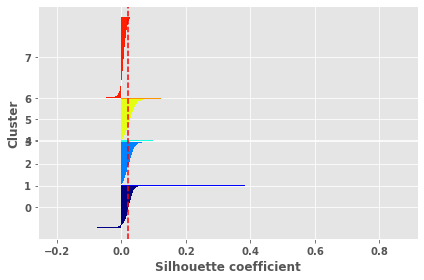

In [79]:
plot_silhouettes(vs_train, newC8)

 ***
##### e. Finally, using your cluster assignments as class labels, categorize each of the documents in the 20% set-aside data into each of the appropriate cluster. Your categorization should be based on Cosine similarity between each test document and cluster centroids. For each test document show the predicted class label as well as Cosine similarity to the corresponding cluster. 
___

##### for each test instance calculate the cosine similarity to each centroid when K  = 5

In [80]:
dist = cosineDist(vs_test, centroids5.T)
dist[100]

array([1., 1., 1., 1., 1.])

In [81]:
# np.ravel(cosineDist(vs_test, centroids5.T))[0]
dist.reshape(-1)[0]

0.9999999185500972

In [82]:
for testDoc in range(len(vs_test)):
#     print(vs_test[testDoc])
    
    for cent in  centroids5:
        print(cent)
#         dist = cosineDist(vs_test[testDoc], cent)
        
#         # flatten the array and determine the distance similarity
#         distSim = 1 - dist.reshape(-1)[0]
        

[0.02 0.   1.13 ... 0.   0.   0.  ]
[0.04 0.   0.05 ... 0.   0.   0.  ]
[0.04 0.   0.07 ... 0.   0.   0.  ]
[0.   0.   0.   ... 1.21 0.   0.  ]
[0.02 0.04 0.01 ... 0.02 0.01 0.07]
[0.02 0.   1.13 ... 0.   0.   0.  ]
[0.04 0.   0.05 ... 0.   0.   0.  ]
[0.04 0.   0.07 ... 0.   0.   0.  ]
[0.   0.   0.   ... 1.21 0.   0.  ]
[0.02 0.04 0.01 ... 0.02 0.01 0.07]
[0.02 0.   1.13 ... 0.   0.   0.  ]
[0.04 0.   0.05 ... 0.   0.   0.  ]
[0.04 0.   0.07 ... 0.   0.   0.  ]
[0.   0.   0.   ... 1.21 0.   0.  ]
[0.02 0.04 0.01 ... 0.02 0.01 0.07]
[0.02 0.   1.13 ... 0.   0.   0.  ]
[0.04 0.   0.05 ... 0.   0.   0.  ]
[0.04 0.   0.07 ... 0.   0.   0.  ]
[0.   0.   0.   ... 1.21 0.   0.  ]
[0.02 0.04 0.01 ... 0.02 0.01 0.07]
[0.02 0.   1.13 ... 0.   0.   0.  ]
[0.04 0.   0.05 ... 0.   0.   0.  ]
[0.04 0.   0.07 ... 0.   0.   0.  ]
[0.   0.   0.   ... 1.21 0.   0.  ]
[0.02 0.04 0.01 ... 0.02 0.01 0.07]
[0.02 0.   1.13 ... 0.   0.   0.  ]
[0.04 0.   0.05 ... 0.   0.   0.  ]
[0.04 0.   0.07 ... 0.   0. 

[0.04 0.   0.05 ... 0.   0.   0.  ]
[0.04 0.   0.07 ... 0.   0.   0.  ]
[0.   0.   0.   ... 1.21 0.   0.  ]
[0.02 0.04 0.01 ... 0.02 0.01 0.07]
[0.02 0.   1.13 ... 0.   0.   0.  ]
[0.04 0.   0.05 ... 0.   0.   0.  ]
[0.04 0.   0.07 ... 0.   0.   0.  ]
[0.   0.   0.   ... 1.21 0.   0.  ]
[0.02 0.04 0.01 ... 0.02 0.01 0.07]
[0.02 0.   1.13 ... 0.   0.   0.  ]
[0.04 0.   0.05 ... 0.   0.   0.  ]
[0.04 0.   0.07 ... 0.   0.   0.  ]
[0.   0.   0.   ... 1.21 0.   0.  ]
[0.02 0.04 0.01 ... 0.02 0.01 0.07]
[0.02 0.   1.13 ... 0.   0.   0.  ]
[0.04 0.   0.05 ... 0.   0.   0.  ]
[0.04 0.   0.07 ... 0.   0.   0.  ]
[0.   0.   0.   ... 1.21 0.   0.  ]
[0.02 0.04 0.01 ... 0.02 0.01 0.07]
[0.02 0.   1.13 ... 0.   0.   0.  ]
[0.04 0.   0.05 ... 0.   0.   0.  ]
[0.04 0.   0.07 ... 0.   0.   0.  ]
[0.   0.   0.   ... 1.21 0.   0.  ]
[0.02 0.04 0.01 ... 0.02 0.01 0.07]
[0.02 0.   1.13 ... 0.   0.   0.  ]
[0.04 0.   0.05 ... 0.   0.   0.  ]
[0.04 0.   0.07 ... 0.   0.   0.  ]
[0.   0.   0.   ... 1.21 0. 

[0.02 0.04 0.01 ... 0.02 0.01 0.07]
[0.02 0.   1.13 ... 0.   0.   0.  ]
[0.04 0.   0.05 ... 0.   0.   0.  ]
[0.04 0.   0.07 ... 0.   0.   0.  ]
[0.   0.   0.   ... 1.21 0.   0.  ]
[0.02 0.04 0.01 ... 0.02 0.01 0.07]
[0.02 0.   1.13 ... 0.   0.   0.  ]
[0.04 0.   0.05 ... 0.   0.   0.  ]
[0.04 0.   0.07 ... 0.   0.   0.  ]
[0.   0.   0.   ... 1.21 0.   0.  ]
[0.02 0.04 0.01 ... 0.02 0.01 0.07]
[0.02 0.   1.13 ... 0.   0.   0.  ]
[0.04 0.   0.05 ... 0.   0.   0.  ]
[0.04 0.   0.07 ... 0.   0.   0.  ]
[0.   0.   0.   ... 1.21 0.   0.  ]
[0.02 0.04 0.01 ... 0.02 0.01 0.07]
[0.02 0.   1.13 ... 0.   0.   0.  ]
[0.04 0.   0.05 ... 0.   0.   0.  ]
[0.04 0.   0.07 ... 0.   0.   0.  ]
[0.   0.   0.   ... 1.21 0.   0.  ]
[0.02 0.04 0.01 ... 0.02 0.01 0.07]
[0.02 0.   1.13 ... 0.   0.   0.  ]
[0.04 0.   0.05 ... 0.   0.   0.  ]
[0.04 0.   0.07 ... 0.   0.   0.  ]
[0.   0.   0.   ... 1.21 0.   0.  ]
[0.02 0.04 0.01 ... 0.02 0.01 0.07]
[0.02 0.   1.13 ... 0.   0.   0.  ]
[0.04 0.   0.05 ... 0.   0. 

[0.   0.   0.   ... 1.21 0.   0.  ]
[0.02 0.04 0.01 ... 0.02 0.01 0.07]
[0.02 0.   1.13 ... 0.   0.   0.  ]
[0.04 0.   0.05 ... 0.   0.   0.  ]
[0.04 0.   0.07 ... 0.   0.   0.  ]
[0.   0.   0.   ... 1.21 0.   0.  ]
[0.02 0.04 0.01 ... 0.02 0.01 0.07]
[0.02 0.   1.13 ... 0.   0.   0.  ]
[0.04 0.   0.05 ... 0.   0.   0.  ]
[0.04 0.   0.07 ... 0.   0.   0.  ]
[0.   0.   0.   ... 1.21 0.   0.  ]
[0.02 0.04 0.01 ... 0.02 0.01 0.07]
[0.02 0.   1.13 ... 0.   0.   0.  ]
[0.04 0.   0.05 ... 0.   0.   0.  ]
[0.04 0.   0.07 ... 0.   0.   0.  ]
[0.   0.   0.   ... 1.21 0.   0.  ]
[0.02 0.04 0.01 ... 0.02 0.01 0.07]
[0.02 0.   1.13 ... 0.   0.   0.  ]
[0.04 0.   0.05 ... 0.   0.   0.  ]
[0.04 0.   0.07 ... 0.   0.   0.  ]
[0.   0.   0.   ... 1.21 0.   0.  ]
[0.02 0.04 0.01 ... 0.02 0.01 0.07]
[0.02 0.   1.13 ... 0.   0.   0.  ]
[0.04 0.   0.05 ... 0.   0.   0.  ]
[0.04 0.   0.07 ... 0.   0.   0.  ]
[0.   0.   0.   ... 1.21 0.   0.  ]
[0.02 0.04 0.01 ... 0.02 0.01 0.07]
[0.02 0.   1.13 ... 0.   0. 

[0.04 0.   0.07 ... 0.   0.   0.  ]
[0.   0.   0.   ... 1.21 0.   0.  ]
[0.02 0.04 0.01 ... 0.02 0.01 0.07]
[0.02 0.   1.13 ... 0.   0.   0.  ]
[0.04 0.   0.05 ... 0.   0.   0.  ]
[0.04 0.   0.07 ... 0.   0.   0.  ]
[0.   0.   0.   ... 1.21 0.   0.  ]
[0.02 0.04 0.01 ... 0.02 0.01 0.07]
[0.02 0.   1.13 ... 0.   0.   0.  ]
[0.04 0.   0.05 ... 0.   0.   0.  ]
[0.04 0.   0.07 ... 0.   0.   0.  ]
[0.   0.   0.   ... 1.21 0.   0.  ]
[0.02 0.04 0.01 ... 0.02 0.01 0.07]
[0.02 0.   1.13 ... 0.   0.   0.  ]
[0.04 0.   0.05 ... 0.   0.   0.  ]
[0.04 0.   0.07 ... 0.   0.   0.  ]
[0.   0.   0.   ... 1.21 0.   0.  ]
[0.02 0.04 0.01 ... 0.02 0.01 0.07]
[0.02 0.   1.13 ... 0.   0.   0.  ]
[0.04 0.   0.05 ... 0.   0.   0.  ]
[0.04 0.   0.07 ... 0.   0.   0.  ]
[0.   0.   0.   ... 1.21 0.   0.  ]
[0.02 0.04 0.01 ... 0.02 0.01 0.07]
[0.02 0.   1.13 ... 0.   0.   0.  ]
[0.04 0.   0.05 ... 0.   0.   0.  ]
[0.04 0.   0.07 ... 0.   0.   0.  ]
[0.   0.   0.   ... 1.21 0.   0.  ]
[0.02 0.04 0.01 ... 0.02 0.0

[0.04 0.   0.07 ... 0.   0.   0.  ]
[0.   0.   0.   ... 1.21 0.   0.  ]
[0.02 0.04 0.01 ... 0.02 0.01 0.07]
[0.02 0.   1.13 ... 0.   0.   0.  ]
[0.04 0.   0.05 ... 0.   0.   0.  ]
[0.04 0.   0.07 ... 0.   0.   0.  ]
[0.   0.   0.   ... 1.21 0.   0.  ]
[0.02 0.04 0.01 ... 0.02 0.01 0.07]
[0.02 0.   1.13 ... 0.   0.   0.  ]
[0.04 0.   0.05 ... 0.   0.   0.  ]
[0.04 0.   0.07 ... 0.   0.   0.  ]
[0.   0.   0.   ... 1.21 0.   0.  ]
[0.02 0.04 0.01 ... 0.02 0.01 0.07]
[0.02 0.   1.13 ... 0.   0.   0.  ]
[0.04 0.   0.05 ... 0.   0.   0.  ]
[0.04 0.   0.07 ... 0.   0.   0.  ]
[0.   0.   0.   ... 1.21 0.   0.  ]
[0.02 0.04 0.01 ... 0.02 0.01 0.07]
[0.02 0.   1.13 ... 0.   0.   0.  ]
[0.04 0.   0.05 ... 0.   0.   0.  ]
[0.04 0.   0.07 ... 0.   0.   0.  ]
[0.   0.   0.   ... 1.21 0.   0.  ]
[0.02 0.04 0.01 ... 0.02 0.01 0.07]
[0.02 0.   1.13 ... 0.   0.   0.  ]
[0.04 0.   0.05 ... 0.   0.   0.  ]
[0.04 0.   0.07 ... 0.   0.   0.  ]
[0.   0.   0.   ... 1.21 0.   0.  ]
[0.02 0.04 0.01 ... 0.02 0.0

In [83]:
test_centroids6

NameError: name 'test_centroids6' is not defined

In [ ]:
clusterCentroids_test = pd.DataFrame(test_centroids6, columns = df_terms[0].values.tolist())

In [ ]:
clusterCentroids_test.head()

In [ ]:
docClusterTest = pd.DataFrame(test_clusterAssment6 , columns = ['Cluster','error']) 

In [ ]:
docClusterTest.shape

In [ ]:
clusterCentroids_test.shape

In [ ]:
type(centroids5)